<a href="https://colab.research.google.com/github/rohitpaul23/kaggleAssign/blob/main/FMnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fasion MNIST Dataset Classification

In [1]:
!pip install opendatasets scikit-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import pandas as pd
import numpy as np
import torch
import os
import opendatasets as od
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader

In [3]:
import torchvision.transforms as transforms
from torch.utils.data import random_split

## Downloading and processing Fashion MNIST Dataset

In [32]:
from torchvision.datasets import FashionMNIST

In [33]:
fashionDataset = FashionMNIST(root='data/', download=True)

In [34]:
len(fashionDataset)

60000

In [35]:
test_dataset = FashionMNIST(root='data/', train=False)
len(test_dataset)

10000

In [36]:
fashionDataset[0]

(<PIL.Image.Image image mode=L size=28x28 at 0x7F71ACC8B210>, 9)

Label: 9


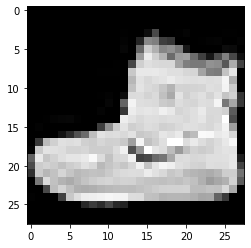

In [37]:
image, label = fashionDataset[0]
plt.imshow(image, cmap='gray')
print('Label:', label)

Label: 0


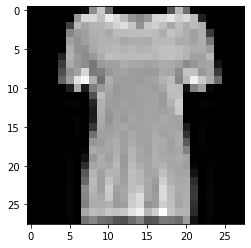

In [38]:
image, label = fashionDataset[10]
plt.imshow(image, cmap='gray')
print('Label:', label)

In [39]:
import torchvision.transforms as transforms

In [40]:
fashionTensorDataset = FashionMNIST(root='data/', 
                      train=True,
                      transform=transforms.ToTensor())

In [41]:
fashionTensorDataset[0][0].shape

torch.Size([1, 28, 28])

In [42]:
fashion_train_ds, fashion_val_ds = random_split(fashionTensorDataset, [50000, 10000])
len(fashion_train_ds), len(fashion_val_ds)

(50000, 10000)

In [43]:
batch_size = 128

fashion_train_loader = DataLoader(fashion_train_ds, batch_size, shuffle=True)
fashion_val_loader = DataLoader(fashion_val_ds, batch_size)

## Using Logistic Regression

In [44]:
fashionTensorDataset[0][0].shape

torch.Size([1, 28, 28])

In [45]:
import torch.nn as nn

input_size = 28*28
output_size = 10

input_size, output_size

(784, 10)

In [46]:
class logistic_model(nn.Module):
    def __init__(self, input_size, output_size):
      super().__init__()
      self.input_size= input_size
      self.output_size = output_size
      self.linear = nn.Linear(input_size, output_size)

    def forward(self, data):
      data = data.reshape(-1, self.input_size)
      out = self.linear(data)
      return out

In [47]:
model = logistic_model(input_size, output_size)

In [48]:
model.linear

Linear(in_features=784, out_features=10, bias=True)

In [49]:
model.linear.weight.shape

torch.Size([10, 784])

In [50]:
for images, labels in fashion_train_loader:
    print(images.shape)
    out = model(images)
    break

out.shape, out[0]

torch.Size([128, 1, 28, 28])


(torch.Size([128, 10]),
 tensor([ 0.0646, -0.4946,  0.6518,  0.2000,  0.0422, -0.4783, -0.3309,  0.1078,
         -0.2014, -0.1266], grad_fn=<SelectBackward0>))

In [51]:
import torch.nn.functional as F

Defining the accuracy function using softmax concept

In [52]:
def accuracy(outs, labels):
  probs = F.softmax(outs, dim=1)
  max_prob, pred = torch.max(probs, dim=1)
  acc = torch.sum(pred == labels)/len(pred)
  return acc

In [53]:
accuracy(out, labels)

tensor(0.0859)

Using cross entropy as a loss function as it is differentiable

In [54]:
loss_func = F.cross_entropy

In [55]:
loss = loss_func(out, labels)
loss

tensor(2.2691, grad_fn=<NllLossBackward0>)

**Combining all the concepts above**

In [56]:
class final_logistic_model(nn.Module):
    def __init__(self, input_size, output_size):
      super().__init__()
      self.input_size= input_size
      self.output_size = output_size
      self.linear = nn.Linear(input_size, output_size)
        
    def forward(self, data):
      data = data.reshape(-1, self.input_size)
      out = self.linear(data)
      return out
    
    #Used in Training in fit()
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    #Calculating the loss used in evaluate()
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss, 'val_acc': acc}
        
    #Output the loss and accuracy obtained used in evaluate()
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        batch_accs = torch.stack(batch_accs).to(float)
        epoch_acc = torch.mean(batch_accs)      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    #To print the result of evaluate function used in fit()
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))
    

In [57]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

Training the Model

In [58]:
def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    optimizer = opt_func(model.parameters(), lr)
    history = [] 
    
    for epoch in range(epochs):
         
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)

    return history

In [59]:
fashion_model = final_logistic_model(input_size, output_size)

In [60]:
result0 = evaluate(fashion_model, fashion_val_loader)
result0

{'val_acc': 0.08494857594936708, 'val_loss': 2.3543262481689453}

In [61]:
history1 = fit(10, 0.001, fashion_model, fashion_train_loader, fashion_val_loader)

Epoch [0], val_loss: 1.7224, val_acc: 0.6024
Epoch [1], val_loss: 1.4291, val_acc: 0.6522
Epoch [2], val_loss: 1.2621, val_acc: 0.6650
Epoch [3], val_loss: 1.1553, val_acc: 0.6725
Epoch [4], val_loss: 1.0810, val_acc: 0.6835
Epoch [5], val_loss: 1.0257, val_acc: 0.6913
Epoch [6], val_loss: 0.9828, val_acc: 0.7002
Epoch [7], val_loss: 0.9484, val_acc: 0.7072
Epoch [8], val_loss: 0.9197, val_acc: 0.7174
Epoch [9], val_loss: 0.8955, val_acc: 0.7232


In [62]:
history2 = fit(10, 0.001, fashion_model, fashion_train_loader, fashion_val_loader)

Epoch [0], val_loss: 0.8748, val_acc: 0.7286
Epoch [1], val_loss: 0.8568, val_acc: 0.7328
Epoch [2], val_loss: 0.8406, val_acc: 0.7386
Epoch [3], val_loss: 0.8261, val_acc: 0.7430
Epoch [4], val_loss: 0.8132, val_acc: 0.7469
Epoch [5], val_loss: 0.8014, val_acc: 0.7496
Epoch [6], val_loss: 0.7906, val_acc: 0.7518
Epoch [7], val_loss: 0.7808, val_acc: 0.7529
Epoch [8], val_loss: 0.7716, val_acc: 0.7546
Epoch [9], val_loss: 0.7633, val_acc: 0.7571


In [63]:
history3 = fit(10, 0.001, fashion_model, fashion_train_loader, fashion_val_loader)

Epoch [0], val_loss: 0.7552, val_acc: 0.7579
Epoch [1], val_loss: 0.7478, val_acc: 0.7609
Epoch [2], val_loss: 0.7411, val_acc: 0.7621
Epoch [3], val_loss: 0.7344, val_acc: 0.7634
Epoch [4], val_loss: 0.7283, val_acc: 0.7649
Epoch [5], val_loss: 0.7226, val_acc: 0.7670
Epoch [6], val_loss: 0.7170, val_acc: 0.7685
Epoch [7], val_loss: 0.7117, val_acc: 0.7704
Epoch [8], val_loss: 0.7068, val_acc: 0.7716
Epoch [9], val_loss: 0.7022, val_acc: 0.7728


In [64]:
history4 = fit(10, 0.001, fashion_model, fashion_train_loader, fashion_val_loader)

Epoch [0], val_loss: 0.6976, val_acc: 0.7738
Epoch [1], val_loss: 0.6933, val_acc: 0.7749
Epoch [2], val_loss: 0.6891, val_acc: 0.7767
Epoch [3], val_loss: 0.6852, val_acc: 0.7776
Epoch [4], val_loss: 0.6814, val_acc: 0.7795
Epoch [5], val_loss: 0.6777, val_acc: 0.7803
Epoch [6], val_loss: 0.6742, val_acc: 0.7822
Epoch [7], val_loss: 0.6708, val_acc: 0.7828
Epoch [8], val_loss: 0.6676, val_acc: 0.7836
Epoch [9], val_loss: 0.6644, val_acc: 0.7848


In [65]:
history5 = fit(10, 0.001, fashion_model, fashion_train_loader, fashion_val_loader)

Epoch [0], val_loss: 0.6613, val_acc: 0.7855
Epoch [1], val_loss: 0.6585, val_acc: 0.7864
Epoch [2], val_loss: 0.6557, val_acc: 0.7872
Epoch [3], val_loss: 0.6530, val_acc: 0.7880
Epoch [4], val_loss: 0.6504, val_acc: 0.7894
Epoch [5], val_loss: 0.6477, val_acc: 0.7896
Epoch [6], val_loss: 0.6452, val_acc: 0.7906
Epoch [7], val_loss: 0.6427, val_acc: 0.7916
Epoch [8], val_loss: 0.6404, val_acc: 0.7926
Epoch [9], val_loss: 0.6380, val_acc: 0.7926


In [66]:
history6 = fit(10, 0.001, fashion_model, fashion_train_loader, fashion_val_loader)

Epoch [0], val_loss: 0.6358, val_acc: 0.7929
Epoch [1], val_loss: 0.6337, val_acc: 0.7943
Epoch [2], val_loss: 0.6315, val_acc: 0.7944
Epoch [3], val_loss: 0.6295, val_acc: 0.7956
Epoch [4], val_loss: 0.6275, val_acc: 0.7962
Epoch [5], val_loss: 0.6256, val_acc: 0.7960
Epoch [6], val_loss: 0.6237, val_acc: 0.7971
Epoch [7], val_loss: 0.6218, val_acc: 0.7975
Epoch [8], val_loss: 0.6201, val_acc: 0.7983
Epoch [9], val_loss: 0.6182, val_acc: 0.7981


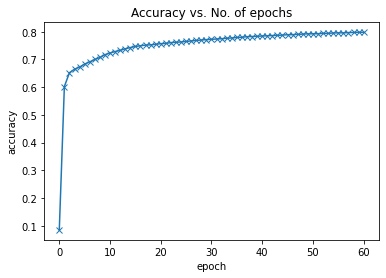

In [67]:
history = [result0] + history1 + history2 + history3 + history4 + history5 + history6
accuracies = [result['val_acc'] for result in history]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs');

After runing 60+ epoch, we are getting a validation accuracy of approx 80%

Prediction on Test Dataset

In [68]:
fashion_test_dataset = FashionMNIST(root='data/', 
                     train=False,
                     transform=transforms.ToTensor())

Label: 9


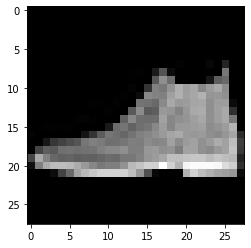

In [69]:
image, label = fashion_test_dataset[0]
plt.imshow(torch.squeeze(image), cmap='gray')
print('Label:', label)

In [70]:
def pred_image(data, model):
  y = model(data)
  _, pred = torch.max(y, dim = 1)
  return pred.item()

In [71]:
pred_image(fashion_test_dataset[0][0], fashion_model)

9

Label: 1


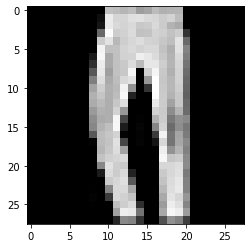

In [72]:
image, label = fashion_test_dataset[5]
plt.imshow(torch.squeeze(image), cmap='gray')
print('Label:', label)

In [73]:
pred_image(fashion_test_dataset[5][0], fashion_model)

1

Label: 4


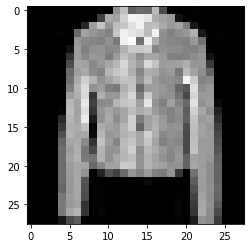

In [74]:
image, label = fashion_test_dataset[10]
plt.imshow(torch.squeeze(image), cmap='gray')
print('Label:', label)

In [75]:
pred_image(fashion_test_dataset[10][0], fashion_model)

2

Label: 2


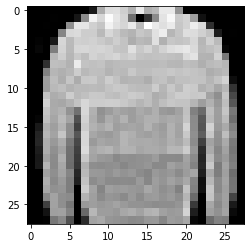

In [76]:
image, label = fashion_test_dataset[20]
plt.imshow(torch.squeeze(image), cmap='gray')
print('Label:', label)

In [77]:
pred_image(fashion_test_dataset[20][0], fashion_model)

0

Logistic Regression was able to give 80.23% accuracy

## Using Neural Network

Defining the model

In [78]:
class neural_Model(nn.Module):
    """Feedfoward neural network with 1 hidden layer"""
    def __init__(self, in_size, hidden_size, out_size):
        super().__init__()
        # hidden layer
        self.linear1 = nn.Linear(in_size, hidden_size)
        # output layer
        self.linear2 = nn.Linear(hidden_size, out_size)
        
    def forward(self, xb):
        # Flattening the image tensors
        xb = xb.view(xb.size(0), -1)
        # Get intermediate outputs using hidden layer
        out = self.linear1(xb)
        # Apply activation function(ReLU)
        out = F.relu(out)
        # Get predictions using output layer
        out = self.linear2(out)
        return out
    
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss, 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

In [79]:
neuralModel = neural_Model(input_size, hidden_size=32, out_size = output_size)

In [80]:
for t in neuralModel.parameters():
    print(t.shape)

torch.Size([32, 784])
torch.Size([32])
torch.Size([10, 32])
torch.Size([10])


Enabling GPU, to speed up the computation

In [81]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [82]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [83]:
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [84]:
fashion_train_loader = DeviceDataLoader(fashion_train_loader, device)
fashion_val_loader = DeviceDataLoader(fashion_val_loader, device)

In [85]:
for xb, yb in fashion_val_loader:
    print('xb.device:', xb.device)
    print('yb:', yb)
    break

xb.device: cuda:0
yb: tensor([0, 7, 2, 4, 4, 3, 1, 6, 9, 3, 9, 9, 1, 6, 4, 5, 5, 6, 2, 0, 8, 9, 3, 1,
        3, 8, 4, 6, 9, 7, 7, 4, 2, 1, 7, 5, 3, 4, 1, 6, 4, 7, 0, 3, 0, 5, 2, 9,
        8, 8, 7, 5, 6, 8, 1, 1, 0, 3, 6, 9, 0, 9, 7, 3, 2, 1, 9, 2, 9, 3, 0, 0,
        2, 5, 0, 5, 5, 0, 0, 7, 3, 2, 7, 1, 0, 4, 9, 8, 5, 2, 2, 3, 0, 2, 8, 7,
        9, 3, 2, 4, 9, 0, 6, 6, 7, 3, 5, 6, 6, 2, 4, 0, 2, 6, 4, 4, 7, 1, 0, 6,
        4, 5, 8, 4, 9, 1, 9, 8], device='cuda:0')


Training the model

In [86]:
def evaluate(model, val_loader):
    """Evaluate the model's performance on the validation set"""
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    """Train the model using gradient descent"""
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [87]:
neuralModel = neural_Model(input_size, hidden_size=32, out_size = output_size)
to_device(neuralModel, device)

neural_Model(
  (linear1): Linear(in_features=784, out_features=32, bias=True)
  (linear2): Linear(in_features=32, out_features=10, bias=True)
)

In [88]:
history = [evaluate(neuralModel, fashion_val_loader)]
history

[{'val_acc': 0.10037579387426376, 'val_loss': 2.324483871459961}]

In [89]:
history += fit(5, 0.05, neuralModel, fashion_train_loader, fashion_val_loader)

Epoch [0], val_loss: 0.6331, val_acc: 0.7780
Epoch [1], val_loss: 0.5425, val_acc: 0.8109
Epoch [2], val_loss: 0.5090, val_acc: 0.8183
Epoch [3], val_loss: 0.5176, val_acc: 0.8177
Epoch [4], val_loss: 0.5075, val_acc: 0.8166


In [90]:
history += fit(5, 0.01, neuralModel, fashion_train_loader, fashion_val_loader)

Epoch [0], val_loss: 0.4605, val_acc: 0.8390
Epoch [1], val_loss: 0.4576, val_acc: 0.8423
Epoch [2], val_loss: 0.4566, val_acc: 0.8401
Epoch [3], val_loss: 0.4569, val_acc: 0.8393
Epoch [4], val_loss: 0.4578, val_acc: 0.8399


In [91]:
history += fit(5, 0.005, neuralModel, fashion_train_loader, fashion_val_loader)

Epoch [0], val_loss: 0.4495, val_acc: 0.8438
Epoch [1], val_loss: 0.4503, val_acc: 0.8430
Epoch [2], val_loss: 0.4479, val_acc: 0.8444
Epoch [3], val_loss: 0.4477, val_acc: 0.8443
Epoch [4], val_loss: 0.4469, val_acc: 0.8451


Using only 16 epochs, able to get validation accuracy of 84.5%

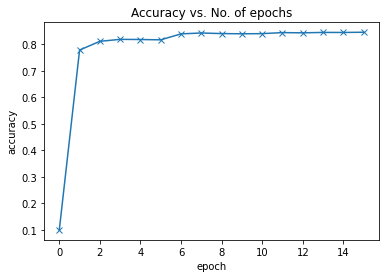

In [92]:
accuracies = [result['val_acc'] for result in history]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs');

Predicting the class for the test image

In [93]:
def neural_pred_image(img, model):
    xb = to_device(img.unsqueeze(0), device)
    yb = model(xb)
    _, preds  = torch.max(yb, dim=1)
    return preds[0].item()

Label: 4


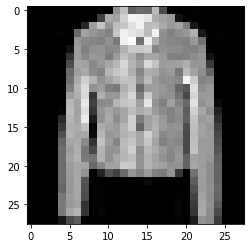

In [94]:
image, label = fashion_test_dataset[10]
plt.imshow(torch.squeeze(image), cmap='gray')
print('Label:', label)

In [95]:
neural_pred_image(fashion_test_dataset[10][0], neuralModel)

4

Label: 0


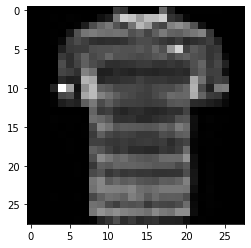

In [96]:
image, label = fashion_test_dataset[35]
plt.imshow(torch.squeeze(image), cmap='gray')
print('Label:', label)

In [97]:
neural_pred_image(fashion_test_dataset[35][0], neuralModel)

0

In [98]:
test_loader = DeviceDataLoader(DataLoader(fashion_test_dataset, batch_size=128), device)
result = evaluate(neuralModel, test_loader)
result

{'val_acc': 0.8390032052993774, 'val_loss': 0.4540216028690338}

By using neural network having single hidden layer, we are able to increase the accuracy from 80.23% to 84.54%

## CONVOLUTIONAL NEURAL NETWORK(CNN)

Defining the model

In [99]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))
        
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [129]:
class fashionMnistCnnModel(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(8, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 14 x 14

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 128 x 7 x 7

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=2, padding=1),
            nn.ReLU(), # output: 256 x 4 x 4

            nn.Flatten(), 
            nn.Linear(256*4*4, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 10))
                
    def forward(self, xb):
        return self.network(xb)

In [130]:
cnnModel = fashionMnistCnnModel()
cnnModel

fashionMnistCnnModel(
  (network): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(8, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (15): ReLU()
    (16): Flatten(start_dim=1, end_dim=-1)
    (17): Linear(in_features=4096, out_features=1024, bias=True)
    (18): ReLU()
    (19): Lin

In [131]:
to_device(cnnModel, device);

In [132]:
for images, labels in fashion_train_loader:
    print('images.shape:', images.shape)
    out = cnnModel(images)
    print('out.shape:', out.shape)
    print('out[0]:', out[0])
    break

images.shape: torch.Size([128, 1, 28, 28])
out.shape: torch.Size([128, 10])
out[0]: tensor([ 0.0158, -0.0433, -0.0061, -0.0391, -0.0215,  0.0012, -0.0135,  0.0371,
        -0.0207, -0.0234], device='cuda:0', grad_fn=<SelectBackward0>)


Training the model

In [133]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [134]:
evaluate(cnnModel, fashion_val_loader)

{'val_acc': 0.09968354552984238, 'val_loss': 2.3027050495147705}

In [135]:
num_epochs = 10
opt_func = torch.optim.Adam
lr = 0.001

In [136]:
history = fit(num_epochs, lr, cnnModel, fashion_train_loader, fashion_val_loader, opt_func)

Epoch [0], train_loss: 0.7701, val_loss: 0.3980, val_acc: 0.8534
Epoch [1], train_loss: 0.3503, val_loss: 0.3477, val_acc: 0.8700
Epoch [2], train_loss: 0.2943, val_loss: 0.2891, val_acc: 0.8938
Epoch [3], train_loss: 0.2603, val_loss: 0.2936, val_acc: 0.8944
Epoch [4], train_loss: 0.2362, val_loss: 0.3041, val_acc: 0.8916
Epoch [5], train_loss: 0.2118, val_loss: 0.2570, val_acc: 0.9086
Epoch [6], train_loss: 0.1895, val_loss: 0.2539, val_acc: 0.9115
Epoch [7], train_loss: 0.1716, val_loss: 0.2607, val_acc: 0.9090
Epoch [8], train_loss: 0.1530, val_loss: 0.2561, val_acc: 0.9194
Epoch [9], train_loss: 0.1365, val_loss: 0.2681, val_acc: 0.9163


In [137]:
history += fit(5, 0.0005, cnnModel, fashion_train_loader, fashion_val_loader, opt_func)

Epoch [0], train_loss: 0.0942, val_loss: 0.2888, val_acc: 0.9187
Epoch [1], train_loss: 0.0714, val_loss: 0.3177, val_acc: 0.9215
Epoch [2], train_loss: 0.0575, val_loss: 0.3442, val_acc: 0.9189
Epoch [3], train_loss: 0.0513, val_loss: 0.3494, val_acc: 0.9243
Epoch [4], train_loss: 0.0417, val_loss: 0.3720, val_acc: 0.9191


In just 15 epoch able to get a validation accuracy of 91.91%

In [138]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

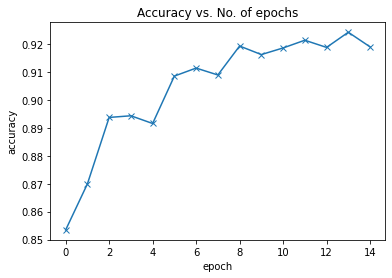

In [139]:
plot_accuracies(history)

By using Convolutional Neural Network setting, able to get an accuracy of 92% increasing it from 84.5%